###Loading packages

In [8]:
import pandas as pd
import numpy as np
import os.path
import json
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import difflib
import re
import seaborn as sns

In [9]:
class data_import() :
    #Constructor to save file paths
    def __init__(self, load_data_path , insi_data_path) :
        self.loan_path = self.check_file(load_data_path)
        self.insi_path = self.check_file(insi_data_path)
        
    #method to check if path is valid
    def check_file(self,path) :
        if os.path.isfile(path) :
            return path
        raise load_data_path + "does not exist"
    
    #Mthod to laod data
    def load_data(self) :
        self.loan_data = pd.read_csv(self.loan_path)
        self.insti_data = pd.read_csv(self.insi_path)
    
    #to merge loan and insitute data
    def merge(self) :
         
        self.loan_insti_data =  pd.merge(self.loan_data, self.insti_data, how='inner',
                                         on = ['Respondent_ID','Agency_Code','As_of_Year'],
                                         suffixes=('_loan', '_insti'))
        
    #method to create Loan  Amount binning
    def Create_Loan_Binned(self) :
        
        self.loan_insti_data["Loan_Amount_binned"] = pd.qcut(self.loan_insti_data['Loan_Amount_000'].values, 4).codes
        
    def hmda_init(self) :
        self.load_data()
        self.merge()
        self.Create_Loan_Binned()
        return(self.loan_insti_data)
    
    #Method to filter data based on states and conventional_conforming. Save data in JSON format
    def hmda_to_json(self, data, states = None, conventional_conforming = None) :
        if states != None :
            self.filter_states = list(states)
        else :
            self.filter_states = list(np.unique(data.State))
            
        if conventional_conforming != None :
            self.filter_con_conf = list(conventional_conforming)
        else :
            self.filter_con_conf = list(np.unique(data.Conventional_Conforming_Flag))
        
        
        self.filtered_data = data[(data['State'].isin(self.filter_states)) & 
                                  (data['Conventional_Conforming_Flag'].isin(self.filter_con_conf))]
        
        
        self.json = self.filtered_data.reset_index().to_json(orient='index')
        
        import json
        with open('json.txt', 'w') as jsonfile:
            json.dump(self.json, jsonfile)
    

In [10]:
loan_path = r"D:\Applied\N start\dump\data-challenge-data-master\data\2012_to_2014_loans_data.csv"
insi_path = r"D:\Applied\N start\dump\data-challenge-data-master\data\2012_to_2014_institutions_data.csv"

In [11]:
obj = data_import(loan_path,insi_path)

In [30]:
expanded_data = obj.hmda_init()

In [31]:
expanded_data["Loan_Amount_binned"].value_counts()

0    308541
3    305674
1    305611
2    303028
Name: Loan_Amount_binned, dtype: int64

In [7]:
obj.hmda_to_json(expanded_data,states = ["VA"])

## Handling duplicates

In [14]:
#Get duplicate rows from data
dup = expanded_data[expanded_data.duplicated(keep=False)]

In [15]:
dup.shape

(8, 34)

In [32]:
#Remove duplicates
expanded_data.drop_duplicates(inplace = True)

###Quality check on Loan_Amount_000

In [17]:
#Check for missing values
sum(expanded_data["Loan_Amount_000"].isnull())

0

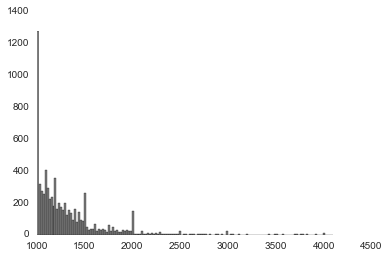

In [18]:
#Distribution of Loan_Amount
loan_amount = expanded_data["Loan_Amount_000"]
#Plot the loan amount data
plt.hist(loan_amount, 150, range=[1000, 4100], facecolor='gray', align='mid')
plt.show()

## Descriptive Statistics

In [19]:
#mean of "loan_amount" 
print "mean is %.2f"%(loan_amount.mean())

mean is 287.09


In [20]:
#median of "loan_amount"
print "median is %.2f"%loan_amount.median()

median is 230.00


In [21]:
#Standard Deviation 
print "Standard Deviation is %.2f"%loan_amount.std()

Standard Deviation is 1002.15


In [22]:
#Range of loan_amount 
print "Range of loan_amount is (" +str(loan_amount.min())+ ","+str(loan_amount.max())+ ")"

Range of loan_amount is (1,99625)


## Handling Outliers 

In [33]:
#Compute 3 standard deviation of Loan AMount
sd_3 = 3*expanded_data.Loan_Amount_000.std()

#Remove outliers
expanded_data = expanded_data[(np.abs(expanded_data.Loan_Amount_000-expanded_data.Loan_Amount_000.mean())<=(sd_3))]

In [34]:
#Create a new column Applicant_Income_binned by binning Applicant_Income_000 into 4 quantiles
expanded_data['Applicant_Income_000'] = pd.to_numeric(expanded_data['Applicant_Income_000'] , errors='coerce')
expanded_data["Applicant_Income_binned"] = pd.qcut(expanded_data['Applicant_Income_000'].values, 4).codes

### Loan Amount is plotted for each of the bin of Application Income bin. For new data see which bin of Applicant Income bin it falls in and check the Loan amount to see if it is an outlier.

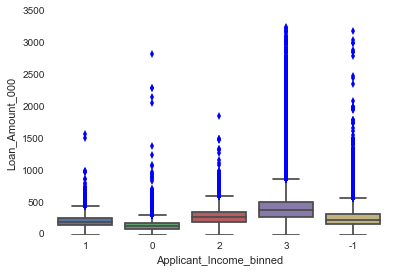

In [35]:
sns.boxplot(expanded_data['Loan_Amount_000'],groupby = expanded_data['Applicant_Income_binned'])

###Quality check on Respondent_Name_TS

In [36]:
print "There are "+str(len(np.unique(expanded_data.Respondent_Name_TS)))+ " banks in dataset"

There are 1576 banks in dataset


In [37]:
#Get bank names length
expanded_data["Respondent_Name_len"] = expanded_data.Respondent_Name_TS.apply(lambda x : len(x))

In [38]:
bank_name_len = expanded_data["Respondent_Name_len"]
print "bank name lenght has range of (" + str(min(bank_name_len))+","+str(max(bank_name_len))+")"

bank name lenght has range of (3,30)


In [39]:
np.unique(expanded_data[expanded_data["Respondent_Name_len"] == 3]["Respondent_Name_TS"])

array(['CNB', 'EVB'], dtype=object)

In [40]:
np.unique(expanded_data[expanded_data["Respondent_Name_len"] == 30]["Respondent_Name_TS"])

array(['167TH TFR FEDERAL CREDIT UNION', '1ST 2ND MORTGAGE CO. OF NJ INC',
       'ABSOLUTE HOME MORTGAGE CORPORA', 'ADVANCIAL FEDERAL CREDIT UNION',
       'AEROSPACE FEDERAL CREDIT UNION', 'AFFINITY LENDING SOLUTIONS, LL',
       'AGRICULTURE FEDERAL CREDIT UNI', "AMERICA'S CHOICE HOME LOANS LP",
       'AMERICAN EQUITY MORTGAGE, INC.', 'AMERICAN FINANCIAL NETWORK INC',
       'AMERICAN FINANCING CORPORATION', 'AMERICAN HERITAGE NATIONAL BAN',
       'AMERICAN INTERNET MORTGAGE INC', 'AMERICAN INTERNET MORTGAGE,INC',
       'AMERICAN MORTGAGE SERVICE COMP', 'AMERICAN NATIONAL BANK & TRUST',
       'AMERICAN NEIGHBORHOOD MORTGAGE', 'AMERICAN SECURITY MORTGAGE COR',
       'AMERICAN SOUTHWEST MORTGAGE CO', 'AMERISAVE MORTGAGE CORPORATION',
       'ASSOCIATED MORTGAGE BANKERS IN', 'ASSOCIATED MORTGAGE BANKERS, I',
       'ASTORIA FEDERAL MORTGAGE CORP.', 'ASTORIA FEDERAL SAVINGS & LOAN',
       'ATLANTIC BAY MORTGAGE GROUPLLC', 'ATLANTIC PACIFIC MORTGAGE CORP',
       'BALTIMORE COUNTY 

### some respondents like "ABSOLUTE HOME MORTGAGE CORPORA"  and "BLACK HILLS FEDERAL CREDIT UNI" were unable to provide complete name due to restriction of lenght of column i.e 30. We can increase the column lenght to overcome this issue. 

In [71]:
#difflib can be used to check the closest match of a given Respondent name from available list of Respondents
#Output can be saved in csv and decision can be made if we need to replace the respondent name with suggested name
Respo_name = set(np.unique(expanded_data["Respondent_Name_TS"]))
s = expanded_data["Respondent_Name_TS"].apply(lambda x : difflib.get_close_matches(x,list(Respo_name- {x})))

In [41]:
#Regular expression can be applied to replace ". ," and extra spaces between words
expanded_data["Respondent_Name_TS"] = expanded_data["Respondent_Name_TS"].map(lambda x : re.sub('[.,]','',x))
expanded_data["Respondent_Name_TS"] = expanded_data["Respondent_Name_TS"].map(lambda x : re.sub(' +',' ',x))

In [42]:
len(np.unique(expanded_data["Respondent_Name_TS"]))

1507

### Applicant_Income_00 can be monitored, as this plays important role in decision of loan sanction. Also there are highchances that applicants may provide false info . Hence quality check would be really handly on this column

In [43]:
#Missing value
Appli_Income_miss = expanded_data[expanded_data["Applicant_Income_000"].isnull()]

In [44]:
print "Applicant_Income_000 column has " + str(Appli_Income_miss.shape[0])+ " missing values"

Applicant_Income_000 column has 108240 missing values


###Applicant Income has alot of missing values. Maybe people here are refusing to disclose their income. People with very high income or with very low income are generally reluctant to disclose their income. We are imputing missing values with median. RandomForest Imputer can also be used to immpute the missing value 

In [45]:
expanded_data["Applicant_Income_000"].fillna(expanded_data["Applicant_Income_000"].median(), inplace=True)

In [46]:
sum(expanded_data["Applicant_Income_000"].isnull())

0

### Relationship between  Applicant_Income_000 and Loan_Amount_000

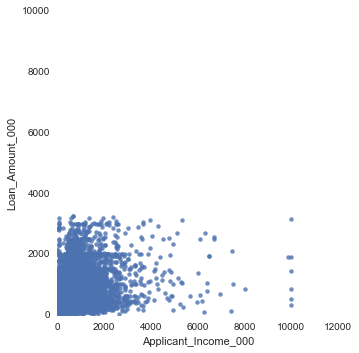

In [47]:
g = sns.lmplot('Applicant_Income_000', 'Loan_Amount_000', 
           data=expanded_data, 
           fit_reg=False)

g.set(ylim=(0, 10000) ,xlim=(0, None) )